# Imports and data loading

In [1]:
import csv
import gzip
import os
import sys
import scipy.io
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torch

import scvi
from scvi.dataset import GeneExpressionDataset, CellMeasurement, AnnDatasetFromAnnData
from scvi.models import VAE, TOTALVI, Classifier
from scvi.inference import TotalPosterior, TotalTrainer, Posterior, UnsupervisedTrainer

import anndata
import scanpy as sc
import umap
import copy

import scanorama
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize

# Control UMAP numba warnings
import warnings; warnings.simplefilter('ignore')

sns.set(context="paper", font_scale=1.15, style="ticks")

sys.path.append("../utils/")
from utils import *

save_path = "/data/yosef2/users/adamgayoso/projects/totalVI_journal/data/"

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ['CUDA_VISIBLE_DEVICES']='1'

set_seed(123)

%load_ext autoreload
%autoreload 2
%matplotlib inline
overwrite = False

/data/yosef2/users/adamgayoso/.pyenv/versions/scvi/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [2]:
colors = ["#3B7EA1", "#FDB515", "#D9661F", "#859438", "#EE1F60", "#00A598"]
sns.set(context="notebook", font_scale=1.3, style="ticks")
sns.set_palette(sns.color_palette(colors))
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['savefig.transparent'] = True
plt.rcParams['figure.figsize'] = (4, 4)
sc.settings._vector_friendly = True
DPI = 300

In [3]:
anndataset_111 = anndata.read(save_path + "spleen_lymph_111.h5ad")
anndataset_111 = anndataset_111[anndataset_111.obs["batch_indices"] == 0]
anndataset_206 = anndata.read(save_path + "spleen_lymph_206.h5ad")
anndataset_206 = anndataset_206[anndataset_206.obs["batch_indices"] == 1]
anndataset_206.obs["batch_indices"] -= 1

Trying to set attribute `.obs` of view, making a copy.


In [4]:
keep_pro_111 = np.array([not p.startswith("HTO") for p in anndataset_111.uns["protein_names"]])
keep_pro_206 = np.array([not (p.startswith("HTO") or p.startswith("ADT_Isotype")) for p in anndataset_206.uns["protein_names"]])
anndataset_206.obsm["protein_expression"] = anndataset_206.obsm["protein_expression"][:, keep_pro_206]
anndataset_206.uns["protein_names"] = anndataset_206.uns["protein_names"][keep_pro_206]
anndataset_111.obsm["protein_expression"] = anndataset_111.obsm["protein_expression"][:, keep_pro_111]
anndataset_111.uns["protein_names"] = anndataset_111.uns["protein_names"][keep_pro_111]

In [5]:
hvg_111 = anndataset_111.var["hvg_encode"]
hvg_206 = anndataset_206.var["hvg_encode"]

assert (hvg_111 == hvg_206).all()

dataset_111 = AnnDatasetFromAnnData(ad=anndataset_111[:, hvg_111])
protein_data_111 = CellMeasurement(
    name="protein_expression",
    data=anndataset_111.obsm["protein_expression"].astype(np.float32),
    columns_attr_name="protein_names",
    columns=anndataset_111.uns["protein_names"],
)
dataset_111.initialize_cell_measurement(protein_data_111)
dataset_111.gene_names = anndataset_111[:, hvg_111].var_names.values

dataset_206 = AnnDatasetFromAnnData(ad=anndataset_206[:, hvg_111])
protein_data_206 = CellMeasurement(
    name="protein_expression",
    data=anndataset_206.obsm["protein_expression"].astype(np.float32),
    columns_attr_name="protein_names",
    columns=anndataset_206.uns["protein_names"],
)
dataset_206.initialize_cell_measurement(protein_data_206)
dataset_206.gene_names = anndataset_206[:, hvg_111].var_names.values

[2020-08-25 20:39:36,671] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-08-25 20:39:36,674] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-08-25 20:39:36,740] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-08-25 20:39:36,805] INFO - scvi.dataset.dataset | Downsampled from 9264 to 9264 cells
[2020-08-25 20:39:37,394] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-08-25 20:39:37,396] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-08-25 20:39:37,447] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-08-25 20:39:37,497] INFO - scvi.dataset.dataset | Downsampled from 7105 to 7105 cells


In [6]:
dataset = GeneExpressionDataset()
dataset.populate_from_datasets(
    [copy.deepcopy(dataset_111), copy.deepcopy(dataset_206)],
    cell_measurement_intersection={"protein_expression": False},
)
batch_mask = dataset.get_batch_mask_cell_measurement("protein_expression")

[2020-08-25 20:39:38,442] INFO - scvi.dataset.dataset | Keeping 4005 genes
[2020-08-25 20:39:38,616] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-08-25 20:39:38,725] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-08-25 20:39:38,728] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-08-25 20:39:38,873] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-08-25 20:39:39,007] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-08-25 20:39:39,010] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-08-25 20:39:39,489] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-08-25 20:39:39,491] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-08-25 20:39:39,497] INFO - scvi.dataset.dataset | Keeping 198 columns in protein_expression


In [7]:
full_data = dataset.X
norm_full_data = anndata.AnnData(X=full_data)
sc.pp.normalize_per_cell(norm_full_data, counts_per_cell_after=1e4)
sc.pp.log1p(norm_full_data)
norm_full_data = anndata.AnnData(
    X=np.concatenate(
        [
            norm_full_data.X,
            np.log1p(dataset.protein_expression),
        ],
        axis=1,
    )
)
col_names = np.concatenate([dataset.gene_names, dataset.protein_names])
norm_full_data.var_names = col_names

In [8]:
norm_full_data.var_names

Index(['Rrs1', 'Sgk3', 'Slco5a1', 'Ly96', 'Mcm3', 'Gsta3', 'Khdc1a', 'Ogfrl1',
       'Prim2', 'Bend6',
       ...
       'ADT_TCRVr3_A0210', 'ADT_TCRbchain_A0120', 'ADT_TCRr-d_A0121',
       'ADT_TER-119-ErythroidCells_A0122', 'ADT_TIGIT(Vstm3)_A0848',
       'ADT_TLR4(CD284)-MD2Complex_A0875', 'ADT_Tim-4_A0567', 'ADT_XCR1_A0568',
       'ADT_anti-P2RY12_A0415', 'ADT_integrinb7_A0214'],
      dtype='object', length=4203)

# Create and run models

In [9]:
datasets = [dataset_111, dataset_206, dataset]
models = []
trainers = []
names = ["SLN_D1_111_harmo_union", "SLN_D2_206_harmo_union", "SLN_harmo_union"]

for d in datasets:

    if d.n_batches > 1:
        m = TOTALVI(
            d.nb_genes,
            d.protein_expression.shape[1],
            n_latent=20,
            n_batch=d.n_batches,
            encoder_batch=True,
            protein_batch_mask=batch_mask,
        )
    else:
        m = TOTALVI(d.nb_genes, d.protein_expression.shape[1], n_latent=20)
    models.append(m)
    use_cuda = True
    lr = 4e-3
    early_stopping_kwargs = {
        "early_stopping_metric": "elbo",
        "save_best_state_metric": "elbo",
        "patience": 45,
        "threshold": 0,
        "reduce_lr_on_plateau": True,
        "lr_patience": 30,
        "lr_factor": 0.6,
        "posterior_class": TotalPosterior,
    }

    trainer = TotalTrainer(
        m,
        d,
        train_size=0.9,
        test_size=0.1,
        use_cuda=use_cuda,
        frequency=1,
        data_loader_kwargs={"batch_size": 256, "pin_memory":False},
        early_stopping_kwargs=early_stopping_kwargs,
        use_adversarial_loss=True if d.n_batches > 1 else False,
        kappa=None
    )
    trainers.append(trainer)
totalvae_111, totalvae_206, totalvae = models[0], models[1], models[2]

In [10]:
if overwrite is True:
    for t, n in zip(trainers, names):
        t.train(lr=lr, n_epochs=500)
        torch.save(t.model.state_dict(), "saved_models/" + n + ".pt")
else:
    for m, n, t in zip(models, names, trainers):
        try:
            m.load_state_dict(torch.load("saved_models/" + n + ".pt"))
            m.eval()
        except FileNotFoundError:
            t.train(lr=lr, n_epochs=500)
            torch.save(t.model.state_dict(), "saved_models/" + n + ".pt")

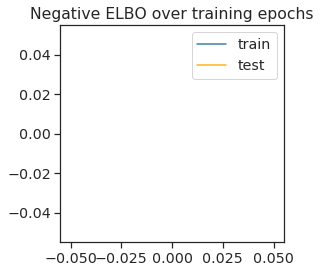

In [11]:
plt.plot(trainers[-1].history["elbo_train_set"][50:], label="train")
plt.plot(trainers[-1].history["elbo_test_set"][50:], label="test")
plt.title("Negative ELBO over training epochs")
# plt.ylim(1750, 1900)
plt.legend()

In [12]:
# create posterior on full data
posteriors = []
latents = []
for t, m, d in zip(trainers, models, datasets):
    full_posterior = t.create_posterior(
        m, d, indices=np.arange(len(d)), type_class=TotalPosterior
    )
    posteriors.append(full_posterior)
    # extract latent space
    latent_mean, batch_index, label, library_gene = full_posterior.sequential().get_latent()
    latents.append(latent_mean)

In [13]:
post_adatas = []
if overwrite:
    for n in names:
        os.remove("saved_post_adata/" + n + ".h5ad")
for d, l, n in zip(datasets, latents, names):
    try:
            post_adatas.append(anndata.read_h5ad("saved_post_adata/" + n + ".h5ad"))
    except OSError:
            post_adata = anndata.AnnData(X=d.X)
            post_adata.var.index = d.gene_names
            post_adata.obsm["X_totalVI"] = l
            sc.pp.neighbors(post_adata, use_rep="X_totalVI", n_neighbors=20, metric="correlation")
            sc.tl.umap(post_adata, min_dist=0.2)
            sc.tl.leiden(post_adata, key_added="leiden_totalVI", resolution=0.8)
            post_adata.write("saved_post_adata/" + n + ".h5ad", compression="gzip")
            post_adatas.append(post_adata)
post_adatas[2].obs["batch_indices"] = datasets[2].batch_indices

Trying to set attribute `.obs` of view, making a copy.
... storing 'totalVI union' as categorical
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


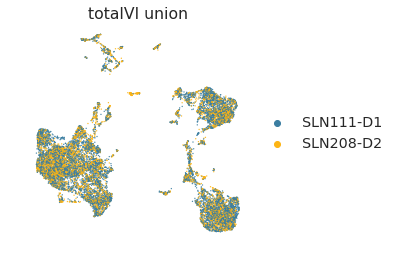

In [14]:
d_names = ["SLN111-D1", "SLN208-D2"]
post_adatas[2].obs["totalVI union"] = [d_names[int(b)] for b in datasets[2].batch_indices]
inds = np.random.permutation(np.arange(datasets[2].X.shape[0]))
fig = sc.pl.umap(
    post_adatas[2][inds], 
    color=["totalVI union"],
    ncols=1,
    alpha=0.9,
    return_fig=True,
    frameon=False,
)
# sns.despine(fig=fig)
# plt.tight_layout()
fig.savefig("figures/totalVI_union_umap.pdf", dpi=DPI, bbox_inches='tight')

In [15]:
parsed_pro_names = [s.split("_")[1].split("(")[0].split("-Er")[0] for s in dataset.protein_names]
for i, p in enumerate(parsed_pro_names):
    post_adatas[2].obs[p] = np.log1p(datasets[2].protein_expression[:, i])

... storing 'totalVI union' as categorical


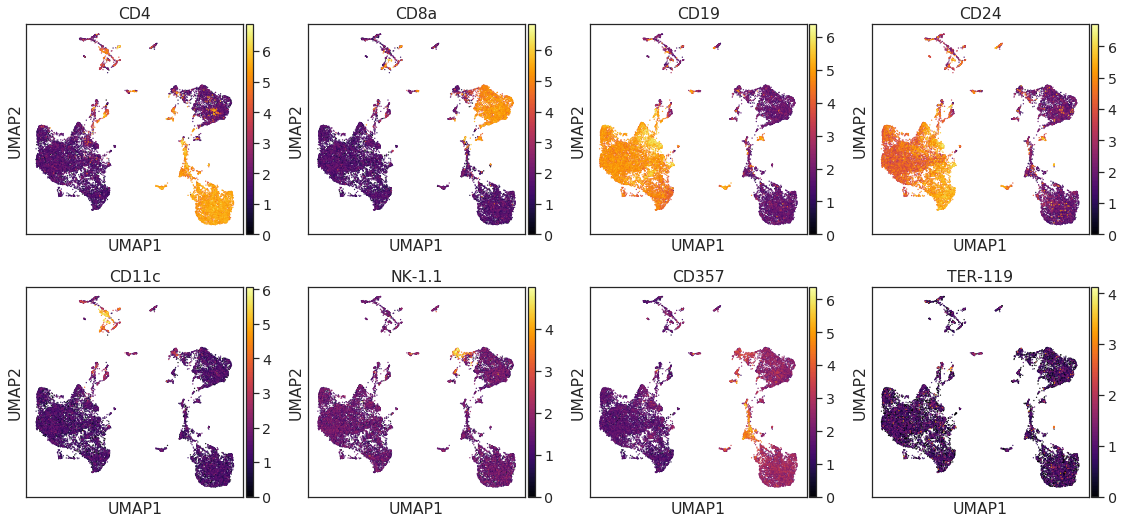

In [16]:
inds = np.random.permutation(np.arange(datasets[2].X.shape[0]))
fig = sc.pl.umap(
    post_adatas[2], 
    color=["CD4", "CD8a", "CD19", "CD24", "CD11c", "NK-1.1" ,"CD357", "TER-119"],
    alpha=0.9,
    return_fig=True,
    frameon=True,
    ncols=4,
    cmap="inferno",
    hspace=0.25,
    wspace=0.18
)
# sns.despine(fig=fig)
fig.savefig("figures/totalVI_union_umap_w_proteins.pdf", dpi=DPI, bbox_inches='tight')

Trying to set attribute `.obs` of view, making a copy.
... storing 'totalVI union' as categorical
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


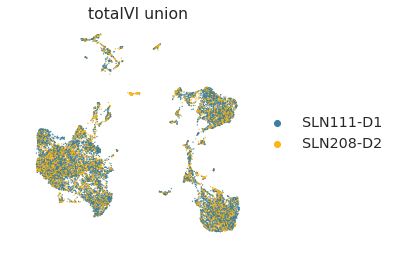

In [17]:
post_adatas[2].obs["totalVI union"] = [d_names[int(b)] for b in datasets[2].batch_indices]
inds = np.random.permutation(np.arange(datasets[2].X.shape[0]))
fig = sc.pl.umap(
    post_adatas[2][inds], 
    color=["totalVI union"],
    ncols=1,
    alpha=0.9,
    return_fig=True,
    frameon=False,
)



# Compute metrics

In [24]:
ENTROPY_K = 100
harmo_metrics = pd.DataFrame(
    index=["totalVI-union"],
    columns=["Mixing metric", "Hotspot metric", "Clustering metric"],
)
harmo_metrics["models"] = [
    "totalVI-union",
]

harmo_metrics.loc["totalVI-union", "Mixing metric"] = entropy_batch_mixing(
    post_adatas[2].obsm["X_totalVI"], datasets[2].batch_indices.ravel(), n_neighbors=ENTROPY_K
)


0.4340521717881361


In [25]:
subset_features = list(anndataset_111.var_names[anndataset_111.var["hvg_encode"]]) + list(anndataset_111.uns["protein_names"])

harmo_metrics.loc["totalVI-union", "Hotspot metric"], _, _ = hotspot_score(
    norm_full_data,
    post_adatas[0].obsm["X_totalVI"],
    post_adatas[1].obsm["X_totalVI"],
    post_adatas[2].obsm["X_totalVI"],
    datasets[2].batch_indices.ravel(),
    subset_features=subset_features,
)

100%|██████████| 4115/4115 [00:01<00:00, 2486.87it/s]


20.96476183388856
19.40663720208119


In [26]:
batch_mask

[array([False,  True,  True, False,  True, False,  True,  True,  True,
        False,  True, False,  True, False,  True,  True,  True,  True,
        False,  True,  True,  True,  True, False, False, False,  True,
        False, False,  True, False,  True, False, False,  True,  True,
        False, False,  True, False, False,  True,  True,  True, False,
        False,  True, False,  True, False, False,  True,  True,  True,
        False,  True,  True,  True, False, False,  True,  True, False,
        False,  True, False, False, False, False,  True,  True, False,
         True, False,  True,  True, False,  True, False,  True,  True,
         True, False, False, False, False, False,  True,  True, False,
        False, False,  True, False,  True,  True,  True, False,  True,
        False, False, False, False,  True,  True, False,  True,  True,
         True,  True,  True, False, False,  True,  True, False,  True,
         True,  True, False,  True,  True,  True,  True,  True,  True,
      

In [27]:
harmo_metrics.loc["totalVI-union", "Clustering metric"] = np.mean(clustering_metric_silhoutte(
    post_adatas[0],
    post_adatas[1],
    post_adatas[2],
    datasets[2].batch_indices.ravel(),
    k=15,
    use_rep="X_totalVI",
    resolution=1.0,
    n_clusters=15,
)
)

In [28]:
harmo_metrics.to_csv("misc_results/sln_d1_111_d2_206_union_stats.csv")

In [29]:
harmo_metrics

,Mixing metric,Hotspot metric,Clustering metric,models
totalVI-union,-0.0262486,0.665524,0.0216028,totalVI-union
